In [ ]:
# !pip install --upgrade numpy

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 9.0MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy.stats.stats import kendalltau
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, Conv1DTranspose
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import activations
sns.set()

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *


# # use this for holdout 25/75 >>>>>>>>>>>>>>>.
train_values = np.empty(shape=[0, 222])
test_values = np.empty(shape=[0, 222])

train_sampled_all = glob.glob('./drive/MyDrive/compsci/train_sampled_all_220.csv')
test_unsampled_all = glob.glob('./drive/MyDrive/compsci/test_unsampled_all_220.csv')

for j in train_sampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_unsampled_all:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# # use this for leave patients >>>>>>>>>>>>>>>.

# train_values = np.empty(shape=[0, 222])
# test_values = np.empty(shape=[0, 222])

# train_patients = glob.glob('./drive/MyDrive/compsci/train_patients.csv')
# test_patients = glob.glob('./drive/MyDrive/compsci/test_patients.csv')

# for j in train_patients:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     train_values = np.append(train_values, csvrows, axis=0)

# for j in test_patients:
#     print('Loading ', j)
#     csvrows = np.loadtxt(j, delimiter=',')
#     test_values = np.append(test_values, csvrows, axis=0)
    
# print(train_values.shape)
# print(test_values.shape)

Loading  ./drive/MyDrive/compsci/train_sampled_all_220.csv
Loading  ./drive/MyDrive/compsci/test_unsampled_all_220.csv
(31912, 222)
(37863, 222)


In [ ]:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train_gc = (y_train - y_train.min())/(y_train.max()-y_train.min())*(9-1)
y_test_gc = (y_test - y_test.min())/(y_test.max()-y_test.min())*(9-1)

In [ ]:
# use this for all data training and testing

X_train1 = X_train.reshape(X_train.shape + (1,1))
X_test1 = X_test.reshape(X_test.shape + (1,1))

y_train1=to_categorical(y_train)
y_test1=to_categorical(y_test)

In [ ]:
# #use this for per class testing

# class_num = 8

# N_train = train_values
# N_test = test_values[test_values[:,-2]==class_num]
# print(N_train.shape)
# print(N_test.shape)

# X_train = N_train[:,:-2]
# X_test = N_test[:,:-2]

# # y_train = train_values[:len(N_train),-2]
# # y_test = test_values[:len(N_test),-2]

# y_train = N_train[:len(N_train),-2]
# y_test = N_test[:len(N_test),-2]

# X_train1 = X_train.reshape(X_train.shape + (1,1,))
# X_test1 = X_test.reshape(X_test.shape + (1,1,))

# y_train1=to_categorical(y_train)
# y_test1=to_categorical(y_test)

In [ ]:
#Use this for noisy test data
# r = np.random.normal(0, 1, X_train.shape)
# noise_train = X_train+r
# print(noise_train.shape)
# X_train1 = noise_train.reshape(noise_train.shape + (1,1))

# s = np.random.normal(0, 0.25, X_test.shape)
# noise_test = X_test+s
# print(noise_test.shape)
# X_test1 = noise_test.reshape(noise_test.shape + (1,1))

In [ ]:
def showResults(test, pred, model_name):
    #target_names = ['positive', 'negative']
    # print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    #loss=log_loss(test,pred)
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    #print("Loss : {}".format(loss))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    print(cm)
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 5, 64
activationFunction='relu'

def getModel():
    
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train1.shape[1],1)))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(MaxPooling1D(pool_size=2,padding='same'))
    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(512, activation='relu'))
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(32, activation='relu'))
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 220, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 128)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 220, 32)           65568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 220, 9)            4617      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 110, 9)            0         
_________________________________________________________________
flatten (Flatten)            (None, 990)               0

In [ ]:
modelhistory= cnnmodel.fit(X_train1[:,:,:,0], y_train1, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Train on 25529 samples, validate on 6383 samples
Epoch 1/5
25529/25529 [==============================] - ETA: 0s - loss: 0.3453 - accuracy: 0.8894

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 37s 1ms/sample - loss: 0.3453 - accuracy: 0.8894 - val_loss: 0.5712 - val_accuracy: 0.7937
Epoch 2/5
25529/25529 [==============================] - 3s 129us/sample - loss: 0.1292 - accuracy: 0.9563 - val_loss: 0.1404 - val_accuracy: 0.9500
Epoch 3/5
25529/25529 [==============================] - 3s 128us/sample - loss: 0.0880 - accuracy: 0.9700 - val_loss: 0.1374 - val_accuracy: 0.9563
Epoch 4/5
25529/25529 [==============================] - 3s 128us/sample - loss: 0.0714 - accuracy: 0.9768 - val_loss: 0.1004 - val_accuracy: 0.9666
Epoch 5/5
25529/25529 [==============================] - 3s 128us/sample - loss: 0.0570 - accuracy: 0.9806 - val_loss: 0.0877 - val_accuracy: 0.9731


In [ ]:
############## Get CAM ################
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

get_last_conv1 = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[4].output])
last_conv1_cnn = get_last_conv1([X_test1[:,:,:,0]])[0]

get_softmax1_cnn = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[-1].output])
softmax1_cnn = get_softmax1_cnn(([X_test1[:,:,:,0]]))[0]
softmax_weight1_cnn = cnnmodel.get_weights()[-1]
softmax_weight_cnn = np.reshape(softmax_weight1_cnn,(9,1))

CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)

# for k in range(1):
#     CAM_cnn = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
#     c = np.exp(CAM_cnn) / np.sum(np.exp(CAM_cnn), axis=1, keepdims=True)
#     plt.figure(figsize=(18, 4))
#     plt.plot(X_test1[k].squeeze())
#     plt.scatter(np.arange(len(X_test1[k])), X_test1[k].squeeze(), cmap='inferno_r', c=c[k,:].squeeze(), s=50)
#     # plt.title('True label:' + str(N_test[k,-2]) + '   likelihood of label ' + str(N_test[k,-2]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
#     plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(softmax1_cnn[k][int(y_test[k])]))
#     plt.clim(0.003,0.010)
#     plt.colorbar()
# plt.show

In [ ]:
cnnpredictions = cnnmodel.predict(X_test1[:,:,:,0], verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy  : 0.95937986952962
Precision : 0.8015143334908579
Recall : 0.954817775837751
f1score : 0.8590309813174261
[[27413    18    44   383   519   206   110    10]
 [    1  1651     0     2     0     0     6     0]
 [    7     1  2477     7     8     0     0     0]
 [   25     2     6  1129     2    25     6     4]
 [   70     0     8     7   679     4     5     0]
 [    7     0     1     7     0   178     0     0]
 [    3     0     0     0     0     1   413    11]
 [    0     0     0     0     0     0    22  2385]]
              precision    recall  f1-score   support

           1      0.996     0.955     0.975     28703
           2      0.987     0.995     0.991      1660
           3      0.977     0.991     0.984      2500
           4      0.736     0.942     0.826      1199
           5      0.562     0.878     0.686       773
           6      0.430     0.922     0.586       193
           7      0.735     0.965     0.834       428
           8      0.990     0.991     0.99

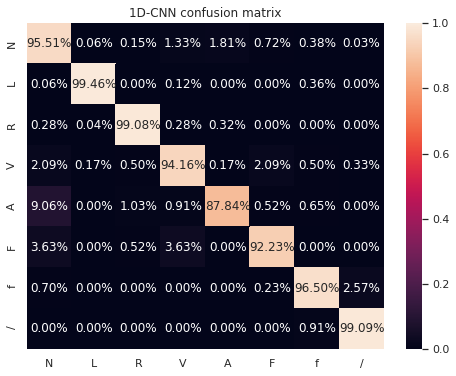

In [ ]:
#performance metrics

cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')
from sklearn import metrics
cnnmetrics = metrics.classification_report(cnn_actual_value, cnn_predict, digits=3)
print(cnnmetrics, 'CNN metrics')
categories=['N','L','R','V','A','F','f','/']
plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1)
plt.title('1D-CNN confusion matrix')
plt.show()

In [ ]:
#Done on LAYER WEIGHTS

from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return
a = last_conv1_cnn
new_last_conv1 = []

for i in range(len(last_conv1_cnn)):
  means = list(means_of_slices(a[i], 20))
  new_last_conv1.append(means)
new_last_conv1 = np.array(new_last_conv1)
print(new_last_conv1.shape)

final_last_conv1 = []
for i in new_last_conv1:
  final_last_conv1.append(np.repeat(i,20))
final_last_conv1 = np.array(final_last_conv1)
print(final_last_conv1.shape)

(37863, 11)
(37863, 220)


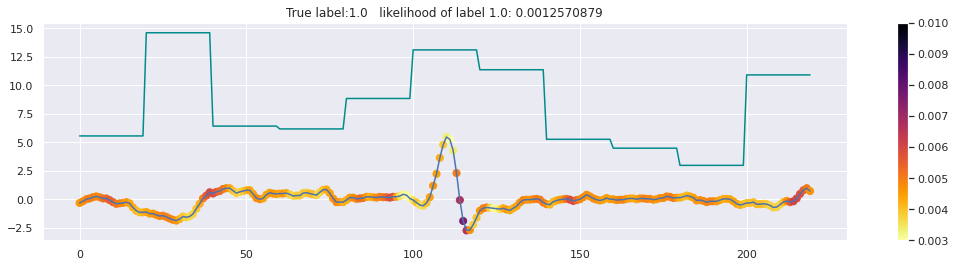

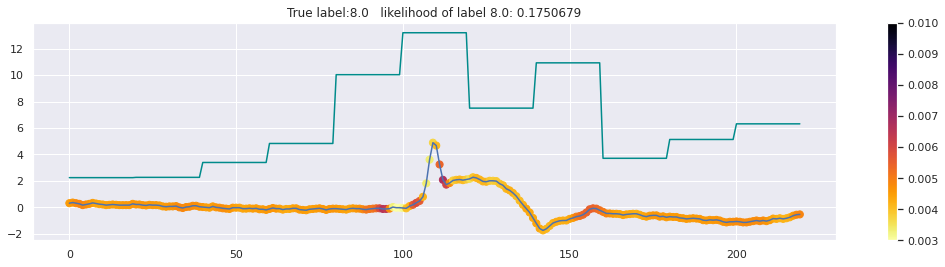

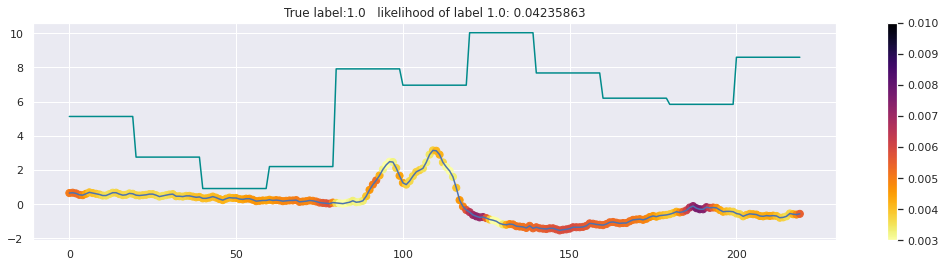

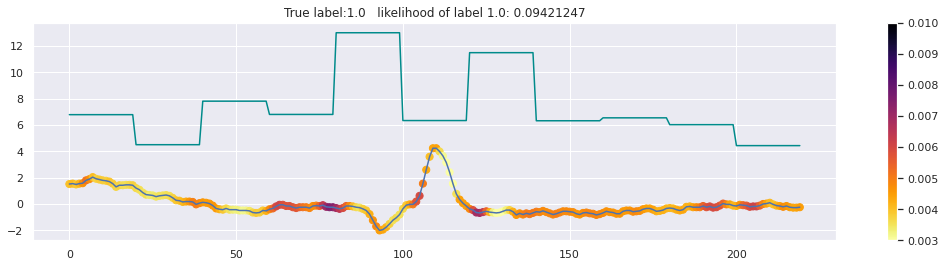

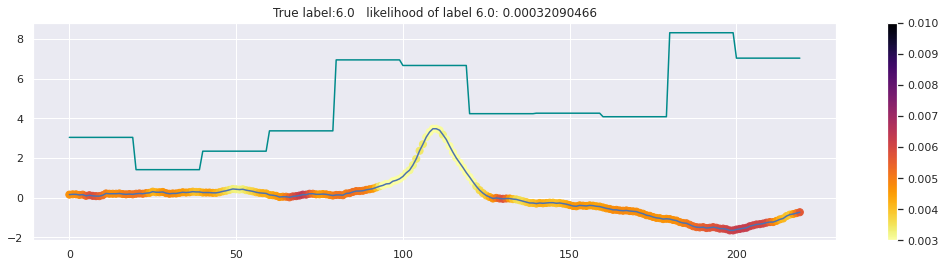

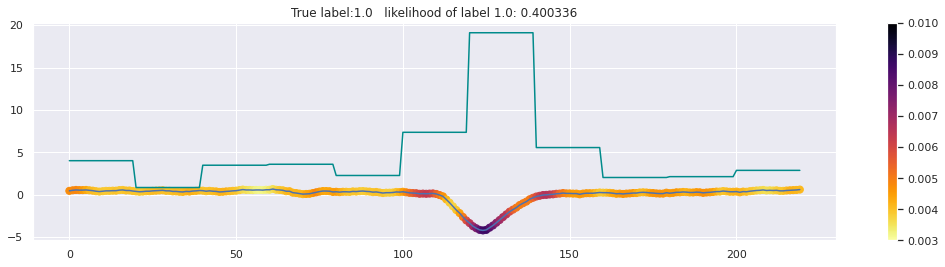

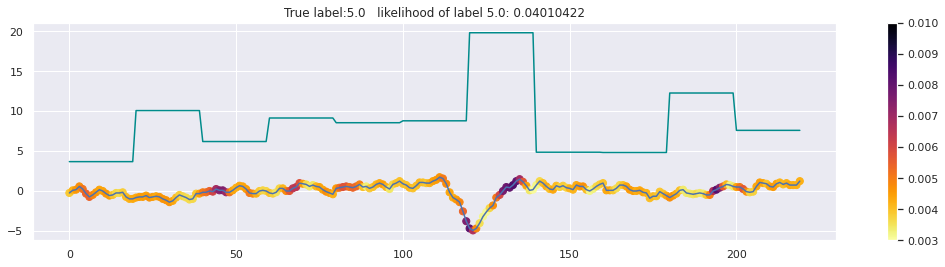

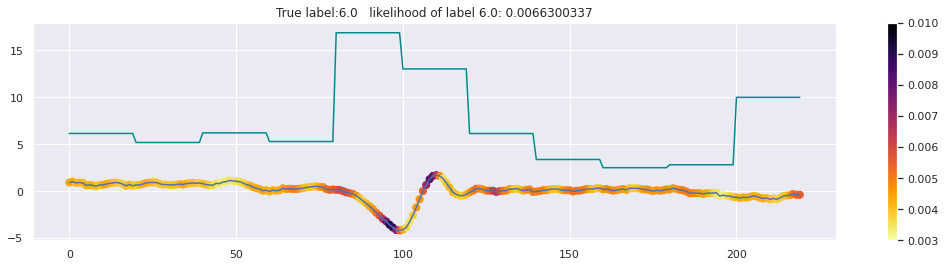

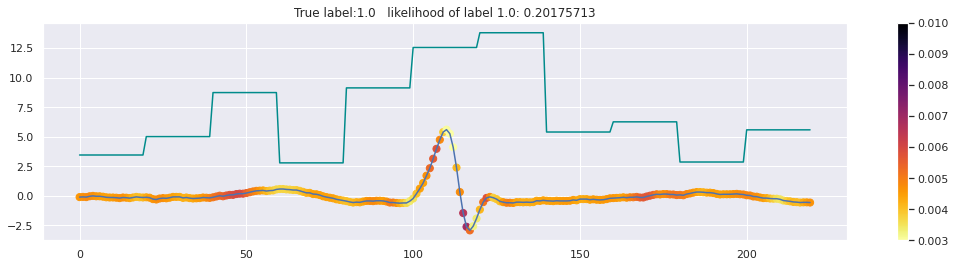

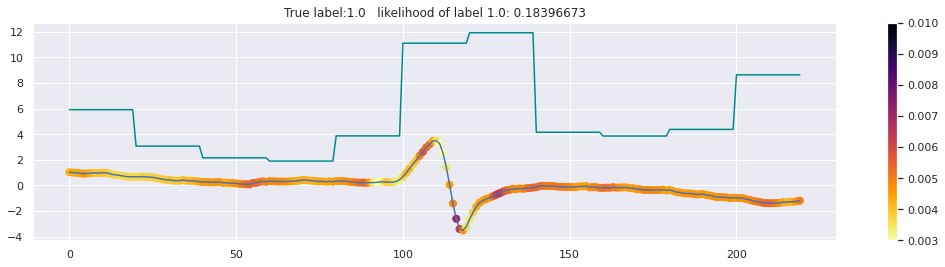

In [ ]:
#misclassified saliency
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

for i in misclass_cnn[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_conv1[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

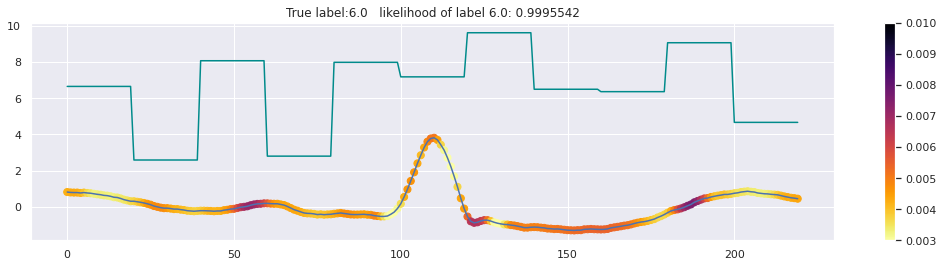

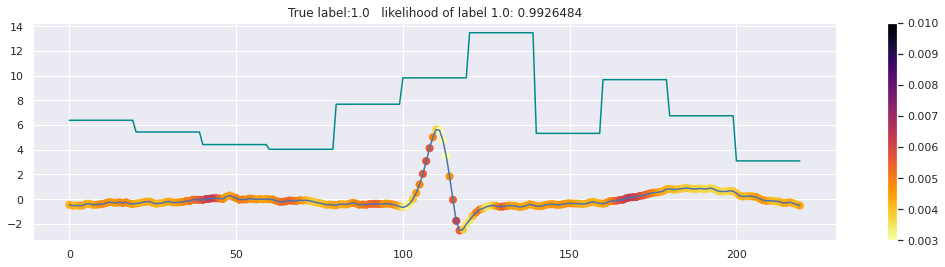

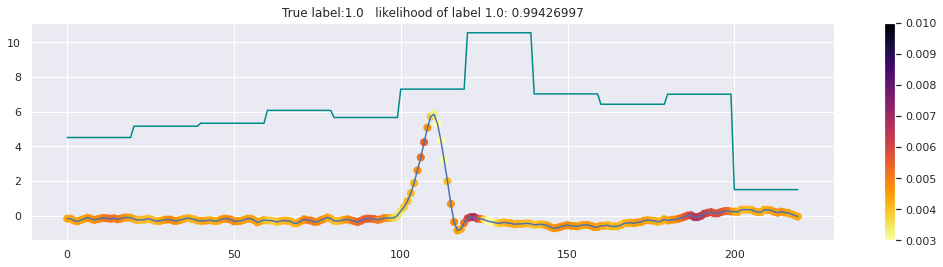

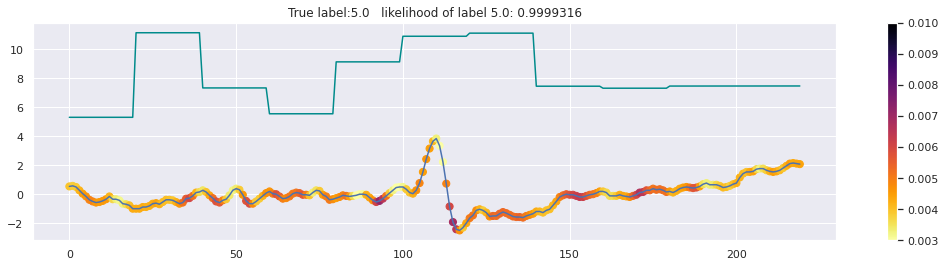

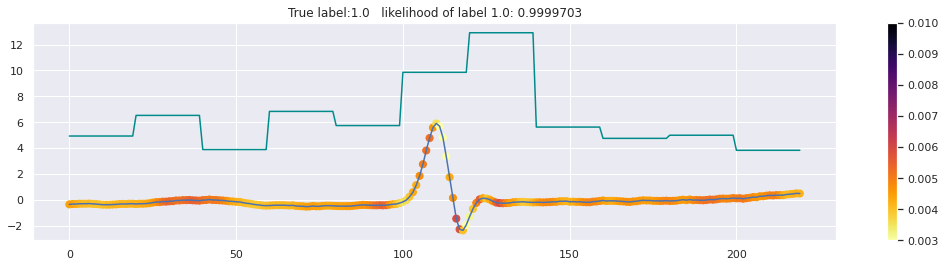

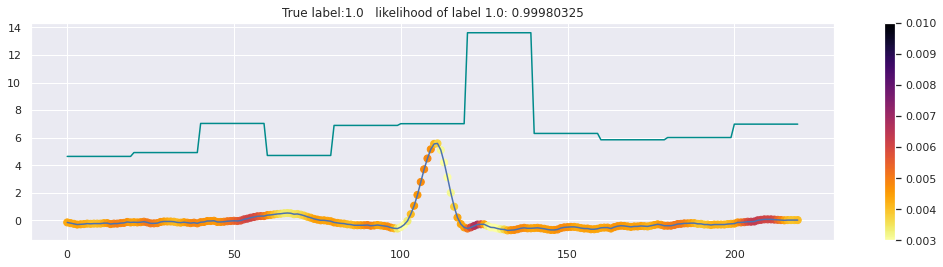

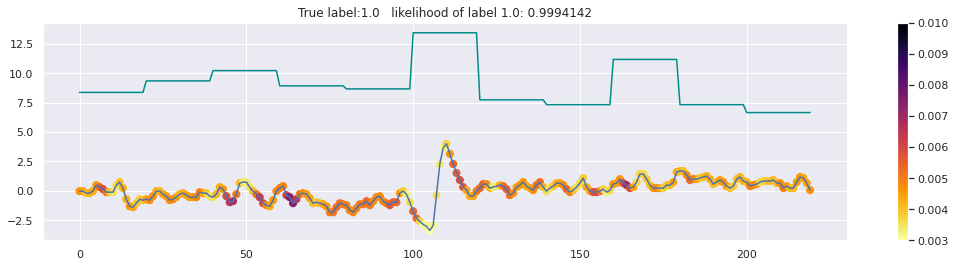

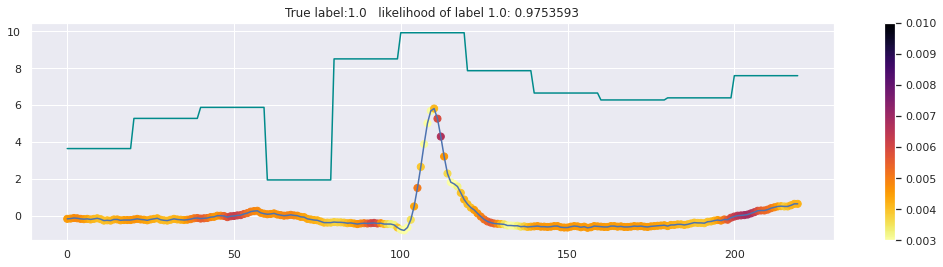

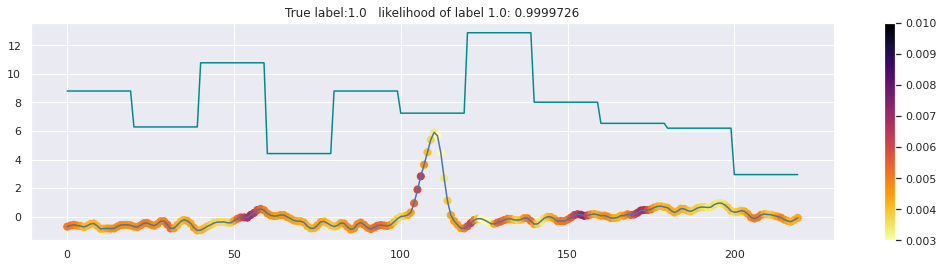

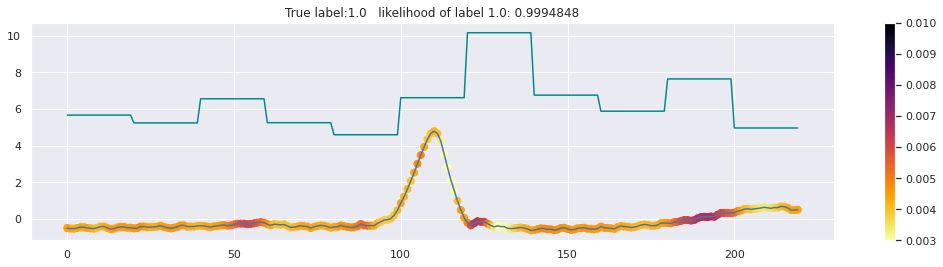

In [ ]:
#correct saliency
correct_cnn = np.where(cnn_predict==cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()

for i in correct_cnn[:10]:
  CAM = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))
  c = np.exp(CAM) / np.sum(np.exp(CAM), axis=1, keepdims=True)
  plt.figure(figsize=(18, 4))
  plt.plot(X_test1[i].squeeze())
  plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=c[i,:].squeeze(), s=50)
  plt.plot(final_last_conv1[i], color = 'darkcyan')
  # plt.title('True label:' + str(N_test[i,-2]) + '   likelihood of label ' + str(N_test[i,-2]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.title('True label:' + str(y_test[i]) + '   likelihood of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
  plt.clim(0.003,0.010)
  plt.colorbar()
  plt.show

In [ ]:
#permutation feature weights

import eli5
from eli5 import format_as_image
from eli5.sklearn import PermutationImportance
from sklearn.neural_network import MLPClassifier
NNMLP_clf = MLPClassifier(random_state=48, max_iter=50)
NNMLP_clf.fit(new_last_conv1, y_test1[:])

perm_all = PermutationImportance(NNMLP_clf).fit(new_last_conv1, y_test1)
print('CNN results')
exp = eli5.explain_weights_df(perm_all, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


CNN results


In [ ]:
perm_corr = PermutationImportance(NNMLP_clf).fit(new_last_conv1[correct_cnn[:]], y_test1[[correct_cnn[:]]])
print('CNN Correct results')
exp_corr = eli5.explain_weights_df(perm_corr, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


CNN Correct results


In [ ]:
perm_mis = PermutationImportance(NNMLP_clf).fit(new_last_conv1[misclass_cnn[:]], y_test1[misclass_cnn[:]])
print('CNN Misclass results')
exp_mis = eli5.explain_weights_df(perm_mis, feature_names = [0,1,2,3,4,5,6,7,8,9,10])

CNN Misclass results


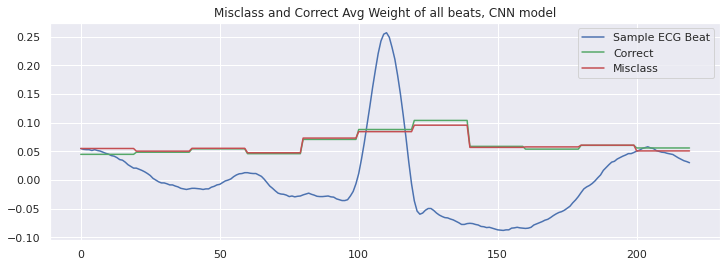

In [ ]:
from sklearn.preprocessing import normalize

n0= normalize(final_last_conv1[correct_cnn[:]])
n1= normalize(final_last_conv1[misclass_cnn[:]])
n2= normalize(X_test1[:,:,0,0])

m0=n0.mean(axis=0)
m1=n1.mean(axis=0)

plt.figure(figsize=(12,4))
plt.plot(n2[0],color='b',label='Sample ECG Beat')
plt.plot(np.abs(m0),color='g',label='Correct')
plt.plot(np.abs(m1),color='r',label='Misclass')
# plt.title('Class: N, Number: ' + str(class_num))
# plt.title('Misclass and Correct Avg Weight of F class, CNN model')
# plt.title('Misclass and Correct Avg Weight of F class on 0.25 std Noise, CNN model')
plt.title('Misclass and Correct Avg Weight of all beats, CNN model')
plt.legend()
plt.show()

In [ ]:
# # saving the model

# model_json = cnnmodel.to_json()
# with open("NEWcnnmodel_testunsam.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# cnnmodel.save_weights("NEWcnnmodel_testunsam_weights.h5")
# cnnmodel.save("NEWcnnmodel_testunsam.h5")
# print("Saved model to disk")

In [ ]:
#done on GRAD-CAM

from itertools import islice
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

a = np.dot(last_conv1_cnn, softmax_weight_cnn)
new_last_conv1 = []

for i in range(len(last_conv1_cnn)):
  means = list(means_of_slices(a[i], 20))
  new_last_conv1.append(means)
new_last_conv1 = np.array(new_last_conv1)
print(new_last_conv1.shape)

final_last_conv1 = []
for i in new_last_conv1:
  final_last_conv1.append(np.repeat(i,20))
final_last_conv1 = np.array(final_last_conv1)
print(final_last_conv1.shape)

(37863, 11)
(37863, 220)


In [ ]:
exp = exp.sort_values(by=['feature'])
exp_corr = exp_corr.sort_values(by=['feature'])
exp_mis = exp_mis.sort_values(by=['feature'])

exp.to_csv('cnn_pfi.csv', encoding='utf-8', index=False)
exp_corr.to_csv('cnn_pfi_corr.csv', encoding='utf-8', index=False)
exp_mis.to_csv('cnn_pfi_mis.csv', encoding='utf-8', index=False)

cnn_pfi = exp.weight.values
cnn_pfi

array([0.03082165, 0.0706917 , 0.0569527 , 0.08927977, 0.11062515,
       0.07187492, 0.12276365, 0.11235243, 0.0570108 , 0.02738822,
       0.04573858])

In [ ]:
# cnn_pfi = pd.read_csv('./drive/MyDrive/compsci/leave_pfi/cnn_pfi.csv')
# # cnn_pfi = pd.read_csv('./drive/MyDrive/compsci/pfi/cnn_pfi.csv')

# cnn_pfi = cnn_pfi.weight.values

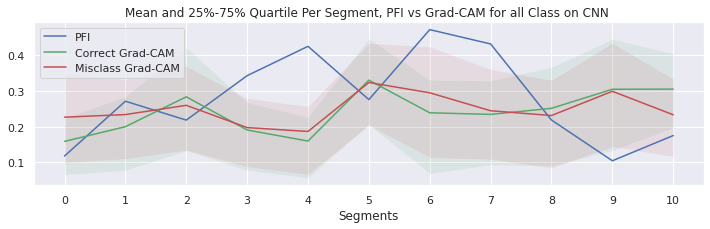

In [ ]:
cnn_pfi = normalize(cnn_pfi.reshape(1,-1))
cnn_pfi = cnn_pfi.ravel()

cnn_grad_corr = normalize(new_last_conv1[correct_cnn[:]])
cnn_grad_mis = normalize(new_last_conv1[misclass_cnn[:]])

cnn_grad_corr = np.abs(cnn_grad_corr)
cnn_grad_mis = np.abs(cnn_grad_mis)

corr = pd.DataFrame(cnn_grad_corr)
df_corr = pd.DataFrame({'mean': corr.mean(), 'median': corr.median(),
                   '25%': corr.quantile(0.25), '50%': corr.quantile(0.5),
                   '75%': corr.quantile(0.75)})

mis = pd.DataFrame(cnn_grad_mis)
df_mis = pd.DataFrame({'mean': mis.mean(), 'median': mis.median(),
                   '25%': mis.quantile(0.25), '50%': mis.quantile(0.5),
                   '75%': mis.quantile(0.75)})

plt.figure(figsize=(12,3))
plt.plot(cnn_pfi,color='b',label='PFI')
plt.plot(df_corr['mean'],color='g',label='Correct Grad-CAM')
plt.fill_between(np.arange(11), df_corr['25%'], df_corr['75%'], alpha=0.1, facecolor="g")
plt.plot(df_mis['mean'],color='r',label='Misclass Grad-CAM')
plt.fill_between(np.arange(11), df_mis['25%'], df_mis['75%'], alpha=0.1, facecolor="r")
plt.title('Mean and 25%-75% Quartile Per Segment, PFI vs Grad-CAM for all Class on CNN ')
plt.xticks(ticks=(0,1,2,3,4,5,6,7,8,9,10))
plt.xlabel('Segments')
plt.legend(loc=2)
plt.show()

In [ ]:
#Use only when running on all data

CNN_results = pd.DataFrame(data=cnn_results,index=('Model','Accuracy','Precision','Recall','F1score','CM'))
print(CNN_results)
CNN_results.to_csv('cnn_results.csv', encoding='utf-8', index=False)

                                                           0
Model                                                    CNN
Accuracy                                               0.959
Precision                                              0.802
Recall                                                 0.955
F1score                                                0.859
CM         [[27413, 18, 44, 383, 519, 206, 110, 10], [1, ...
